In [ ]:
#pytorch

In [ ]:
import torch
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
lfw_torched = torch.from_numpy(lfw_people.data)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_torched.data

n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target #.target contains the actual integer class labels
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)




cuda
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


torch.Size([966, 150])
torch.Size([322, 150])


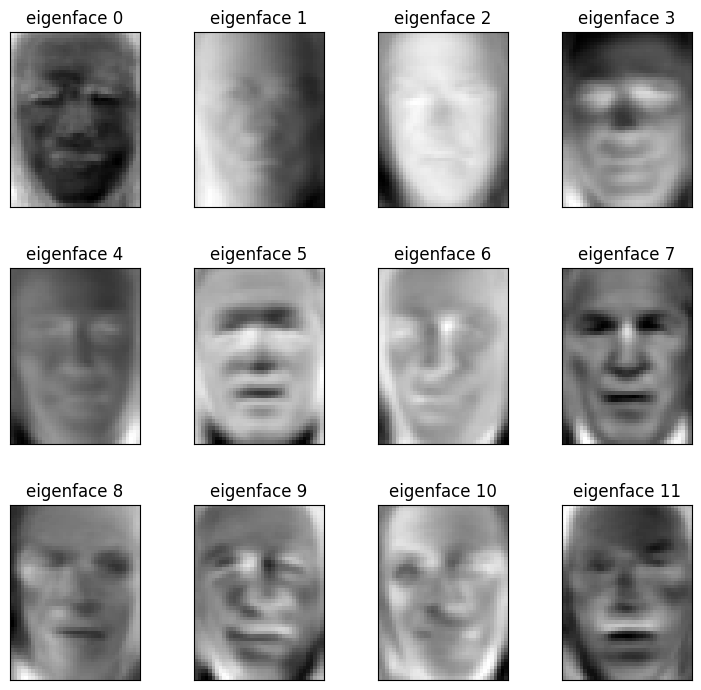

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#X_train = X_train.clone().detach()
y_train = torch.tensor(y_train)
#X_test = X_test.clone().detach()
y_test = torch.tensor(y_test)

#print(type(X_train))
#print(type(X_test))
#print(type(y_train))
#print(type(y_test))

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

n_components = 150 #each principal component represents an "eigenface."
#These eigenfaces are essentially basis vectors that capture different patterns or features in the images

# Center the data by subtracting the mean of the training set from both the training and testing sets.
#(common preprocessing step in PCA to remove the mean and make the data have zero mean.)
mean = torch.mean(X_train, axis=0)
X_train -= mean
X_test -= mean

#Eigen-decomposition
#(components selects the top n_components eigenvectors.eigenfaces reshapes these components back into images, representing the eigenfaces.)
U, S, V = torch.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

#project into PCA subspace
X_transformed = torch.matmul(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = torch.matmul(X_test, components.T)
print(X_test_transformed.shape)

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
#plt.show()



torch.Size([966])


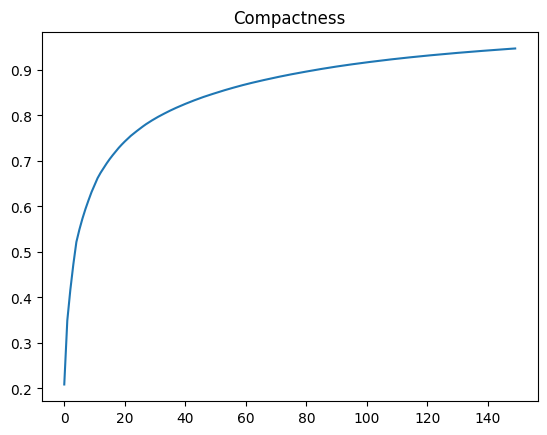

Total Testing 322
Predictions tensor([3, 3, 6, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 1, 1, 3, 3,
        1, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3,
        4, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 6, 1, 3, 1, 3, 5, 3, 4, 1, 3, 6, 1,
        3, 3, 3, 2, 3, 6, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 6, 3, 1, 1, 3,
        1, 1, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 6, 3, 3, 3, 1, 4, 1, 3,
        1, 3, 3, 1, 3, 4, 5, 3, 1, 3, 6, 6, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 3, 1,
        3, 3, 3, 3, 6, 1, 4, 3, 1, 3, 3, 3, 6, 3, 3, 3, 6, 5, 5, 1, 3, 3, 5, 1,
        3, 3, 1, 3, 3, 1, 5, 3, 3, 3, 3, 5, 3, 3, 3, 1, 3, 3, 3, 3, 1, 2, 6, 3,
        2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 5, 1, 3, 2, 4, 3, 3, 5, 3, 3, 3, 4,
        3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 6, 3, 3, 3,
        3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 2, 3, 4, 3, 4, 3, 1, 3, 3, 3, 3, 3, 1,
        3, 6, 6, 1, 6, 1, 6, 3, 3, 3, 6, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3,
        3,

In [ ]:

explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = torch.cumsum(explained_variance_ratio, dim=0)
# indicates how much of the total variance is explained when considering the first n principal components
print(ratio_cumsum.shape)
eigenvalueCount = torch.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()


#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150) #learning algorithm based on decision trees.
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

#Predictions are made on the test data (X_test_transformed) using the trained Random Forest classifier.
#checks which predictions are correct and stores the results in the correct variable.
predictions = torch.tensor(estimator.predict(X_test_transformed))
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",torch.sum(correct))
print("Accuracy:",torch.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names, zero_division=1))
